In [59]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.tsa as tsa
from statsmodels.graphics import tsaplots

In the following cell, I'm merely setting my notebook's working directory to the location where I've stored the NASA data. If you wish to run this code on your local machine, you'll of course need to change this line so that you're accessing the appropriate directory. 

In [64]:
cd ~/umn_bootcamp/umn_bootcamp_capstone_project/NASA_data/nasa_data/PM_2point5_data/surface_density_hourly

/Users/josephmacula/umn_bootcamp/umn_bootcamp_capstone_project/NASA_data/nasa_data/PM_2point5_data/surface_density_hourly


The NASA data are hourly readings, while the aqicn.org data are daily readings. The following cell takes the daily average of the hourly NASA data to make direct comparisons feasible. 

In [60]:
def read_in_NASA_data(file_path = None):

    if file_path != None:
        my_path = file_path
    else:
        my_path = os.getcwd()
    files = [file for file in os.listdir(my_path) if file.endswith('.csv')]
    cities_PM2point5 = {}
    for file in files:
        name = file[:-4]
        df = pd.read_csv(file)
        cities_PM2point5[name] = df
        cities_PM2point5[name].rename(columns = {'Title:' : 'date', 'Time Series, Area-Averaged of Bias corrected surface total PM2.5 mass concentration - all quality levels hourly 0.5 x 0.625 (hourly)': 'pm25_µg_m3_' + name}, inplace = True)
        cities_PM2point5[name] = cities_PM2point5[name][cities_PM2point5[name]['pm25_µg_m3_'+name] != -999]
        cities_PM2point5[name] = cities_PM2point5[name].iloc[7:,:]
        cities_PM2point5[name]['date'] = pd.to_datetime(cities_PM2point5[name]['date'])
        cities_PM2point5[name]['day'] = cities_PM2point5[name]['date'].dt.to_period('D')
        cities_PM2point5[name]['day'] = cities_PM2point5[name]['day'].dt.start_time
        cities_PM2point5[name]['pm25_µg_m3_'+name] = cities_PM2point5[name]['pm25_µg_m3_'+name].astype(float)
        cities_PM2point5[name] = cities_PM2point5[name][['day', 'pm25_µg_m3_'+name]]
        cities_PM2point5[name] = cities_PM2point5[name].groupby(['day'])['pm25_µg_m3_'+name].mean().reset_index()
    return cities_PM2point5

In [74]:
cd ~/umn_bootcamp/umn_bootcamp_capstone_project/aqicn_data

/Users/josephmacula/umn_bootcamp/umn_bootcamp_capstone_project/aqicn_data


Now we read in the aqicn data and clean it up just a little bit

In [23]:
aqicn_cities = ['baotou.csv','chengdu.csv','ganzhou.csv','guangzhou.csv','kunming.csv','panzhihua.csv','quanzhou.csv','shanghai.csv','shenzhen.csv','wuhan.csv']

aqicn_data = {}
for i in aqicn_cities:
    name = i[:-4]
    df = pd.read_csv(i)
    aqicn_data[name] = df
    aqicn_data[name]['date'] = pd.to_datetime(aqicn_data[name]['date'])

In [79]:
def read_in_aqicn_data(file_path = None):
    if file_path != None:
        my_path = file_path
    else:
        my_path = os.getcwd()
        print(my_path)
    files = [file for file in os.listdir(my_path) if file.endswith('.csv')]
    aqicn_data = {}
    for file in files:
        name = file[:-4]
        df = pd.read_csv(file)
        aqicn_data[name] = df
        aqicn_data[name]['date'] = pd.to_datetime(aqicn_data[name]['date'])
    return aqicn_data

We need to convert either the aqicn data to raw concentrations, or the NASA data to AQI scores. We choose to do the latter. The function below is just the US EPA's conversion function, which is the standard aqicn uses. Note that the specific thresholds are those of the pre-2024 US EPA standard; aqicn has not yet updated to account for the most recent changes. 

In [24]:
def concentration_to_AQI(concentration):
    if concentration <= 12:
        concentration_low = 0
        concentration_high = 12
        AQI_low = 0
        AQI_high = 50
        AQI = ( ( (AQI_high-AQI_low)/(concentration_high - concentration_low) )*(concentration - concentration_low) ) + AQI_low
    elif concentration <= 35.4:
        concentration_low = 12.1
        concentration_high = 35.4
        AQI_low = 51
        AQI_high = 100
        AQI = ( ( (AQI_high-AQI_low)/(concentration_high - concentration_low) )*(concentration - concentration_low) ) + AQI_low
    elif concentration <= 55.4:
        concentration_low = 35.5
        concentration_high = 55.4
        AQI_low = 101
        AQI_high = 150
        AQI = ( ( (AQI_high-AQI_low)/(concentration_high - concentration_low) )*(concentration - concentration_low) ) + AQI_low
    elif concentration <= 150.4:
        concentration_low = 55.5
        concentration_high = 150.4
        AQI_low = 151
        AQI_high = 200
        AQI = ( ( (AQI_high-AQI_low)/(concentration_high - concentration_low) )*(concentration - concentration_low) ) + AQI_low
    elif concentration <= 250.4:
        concentration_low = 150.5
        concentration_high = 250.4
        AQI_low = 201
        AQI_high = 300
        AQI = ( ( (AQI_high-AQI_low)/(concentration_high - concentration_low) )*(concentration - concentration_low) ) + AQI_low
    elif concentration <= 350.4:
        concentration_low = 250.5
        concentration_high = 350.4
        AQI_low = 301
        AQI_high = 400
        AQI = ( ( (AQI_high-AQI_low)/(concentration_high - concentration_low) )*(concentration - concentration_low) ) + AQI_low
    else:
        concentration_low = 350.5
        concentration_high = 500
        AQI_low = 401
        AQI_high = 500
        AQI = ( ( (AQI_high-AQI_low)/(concentration_high - concentration_low) )*(concentration - concentration_low) ) + AQI_low
    return AQI

We perform some further data cleaning to get the data ready to plot. 

In [25]:
merged_data = []
for i in list(aqicn_data.keys()):
    combined_df = cities_PM2point5[i.capitalize()].merge(aqicn_data[i], how = 'left', left_on = 'day', right_on = 'date')
    merged_data.append(combined_df)

for i in range(0, len(merged_data)):
    merged_data[i]['converted_NASA_concentrations'] = merged_data[i].iloc[:,1].apply(lambda x: round(concentration_to_AQI(x)))
    merged_data[i] = merged_data[i].dropna()
    merged_data[i] = merged_data[i][merged_data[i][' pm25'] != ' ']
    merged_data[i][' pm25'] = pd.to_numeric(merged_data[i][' pm25'])

In [26]:
def pm25daily_comparison_plots(i):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.plot(merged_data[i]['day'], merged_data[i].iloc[:,1], label = 'NASA estimates')
    ax.plot(merged_data[i]['day'], merged_data[i][' pm25'], label = 'aqicn data')
    plt.legend()
    plt.title(list(merged_data[i].columns)[1][11::] + ' daily AQI from estimated PM 2.5 concentrations')
    plt.show()

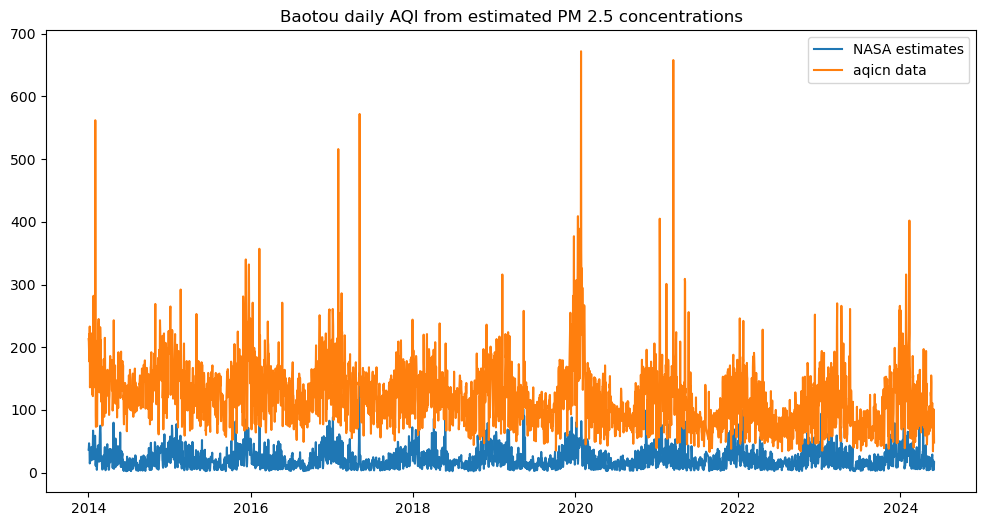

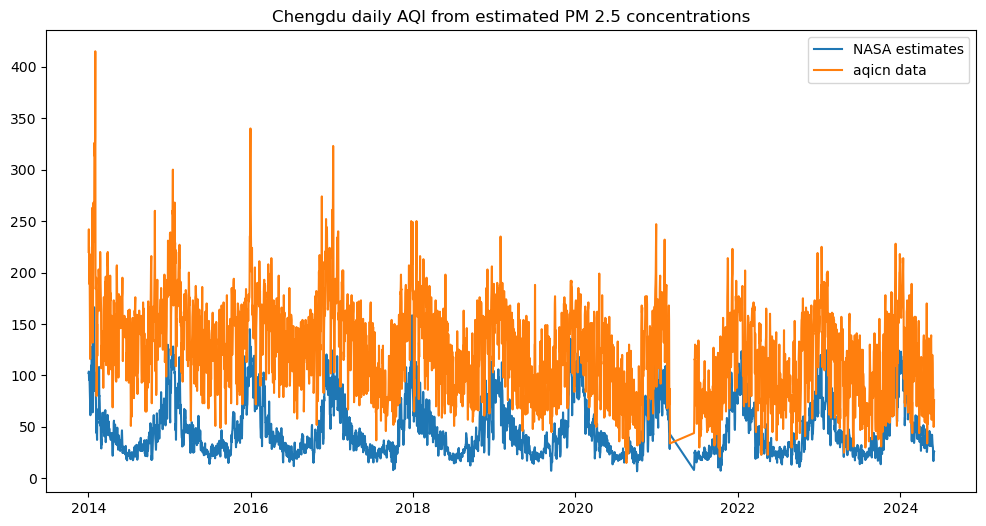

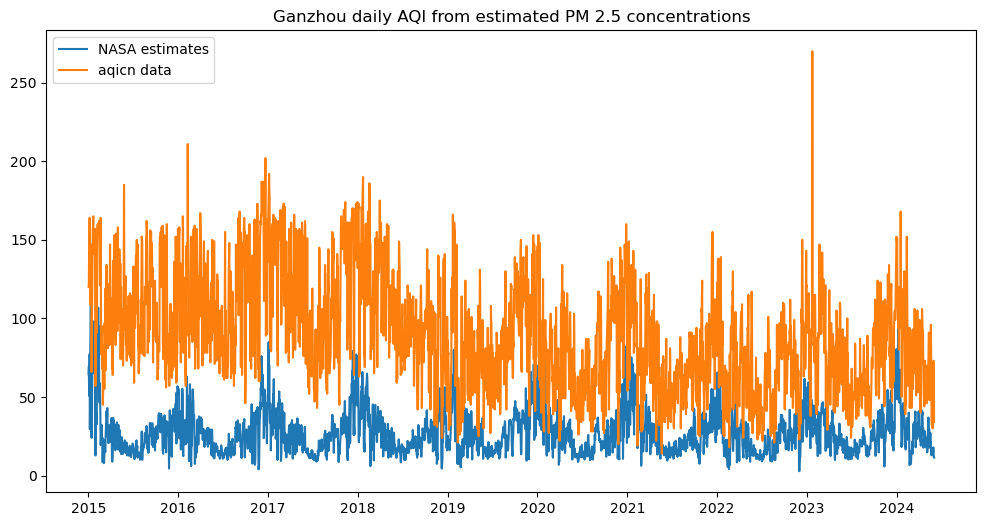

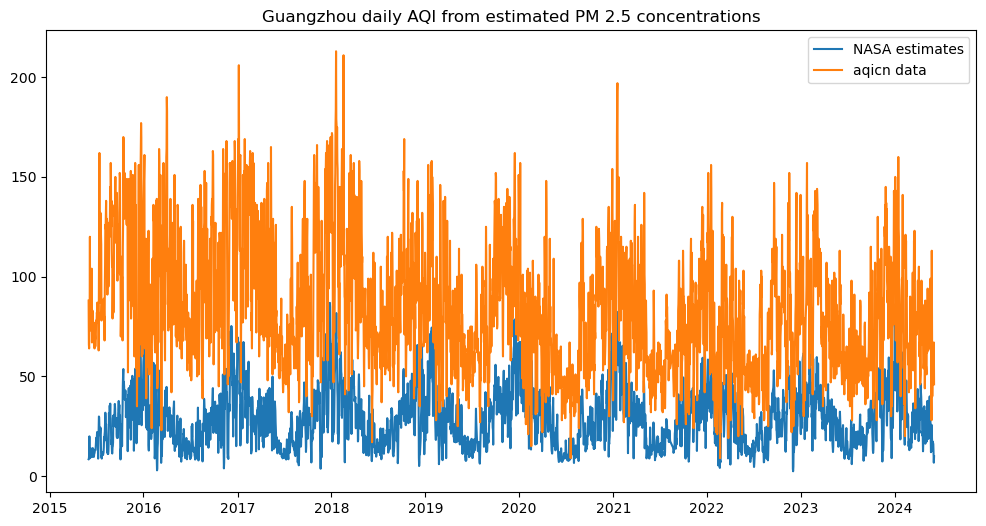

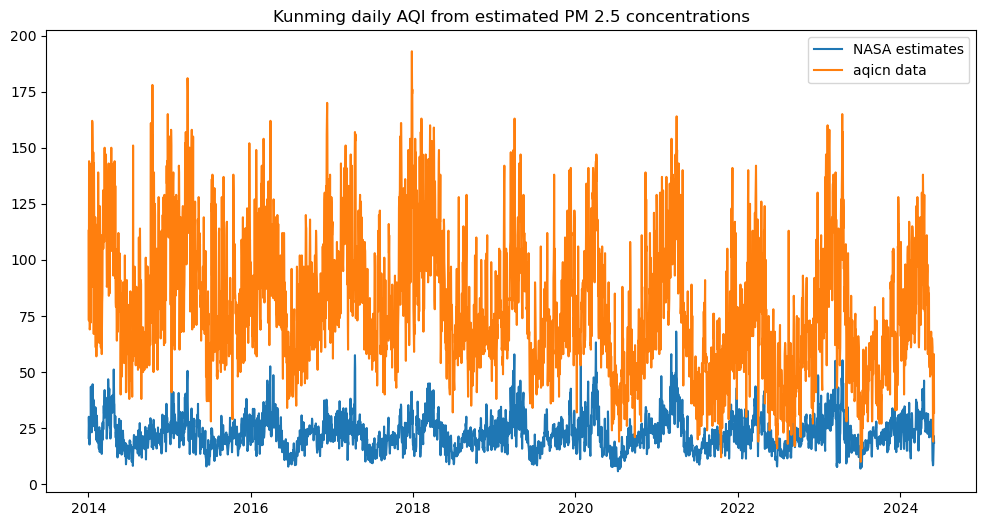

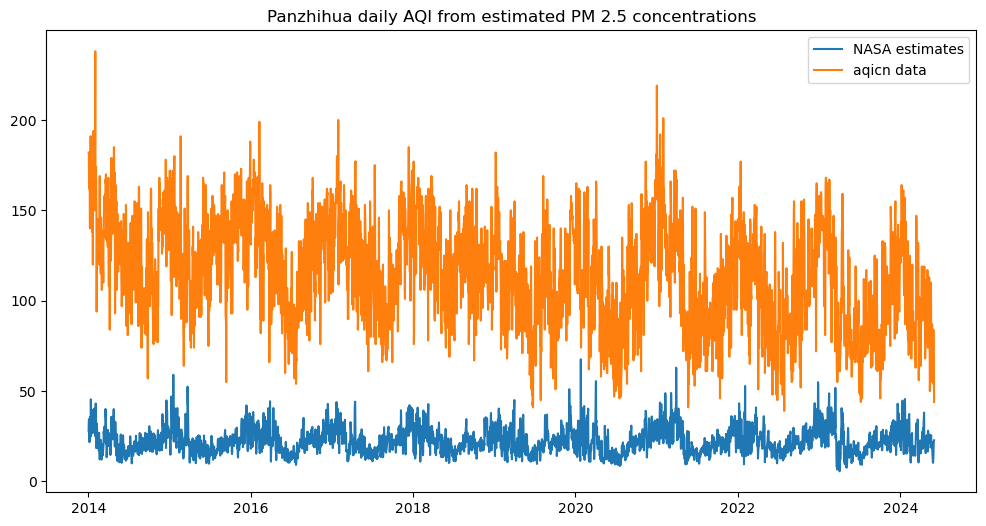

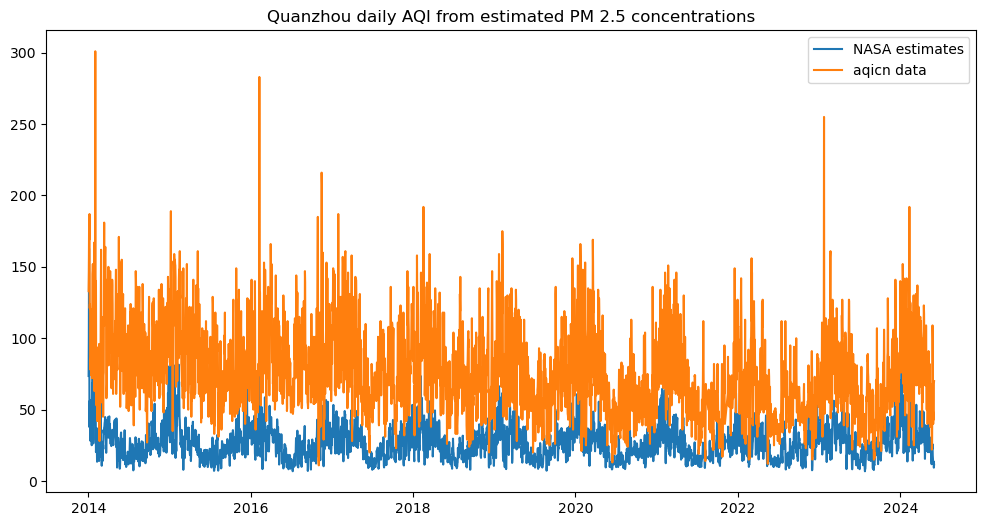

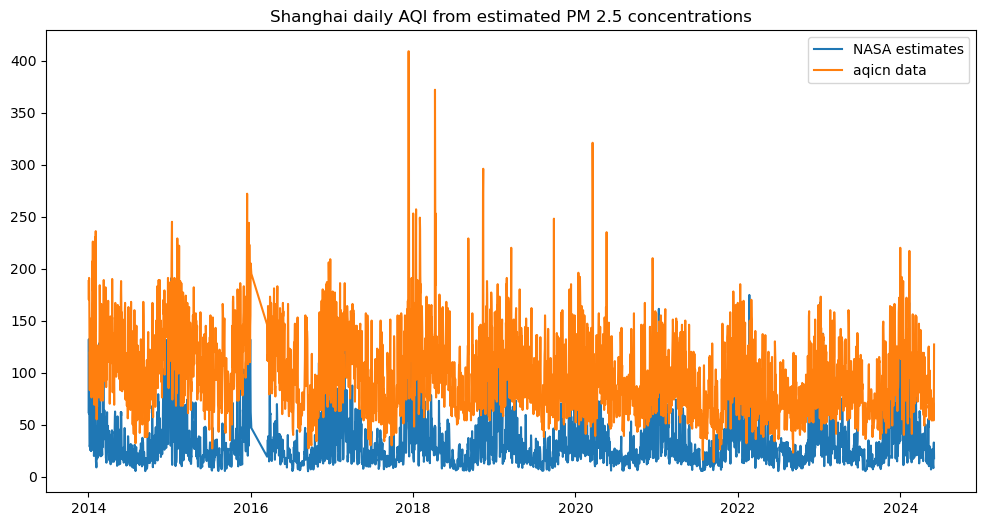

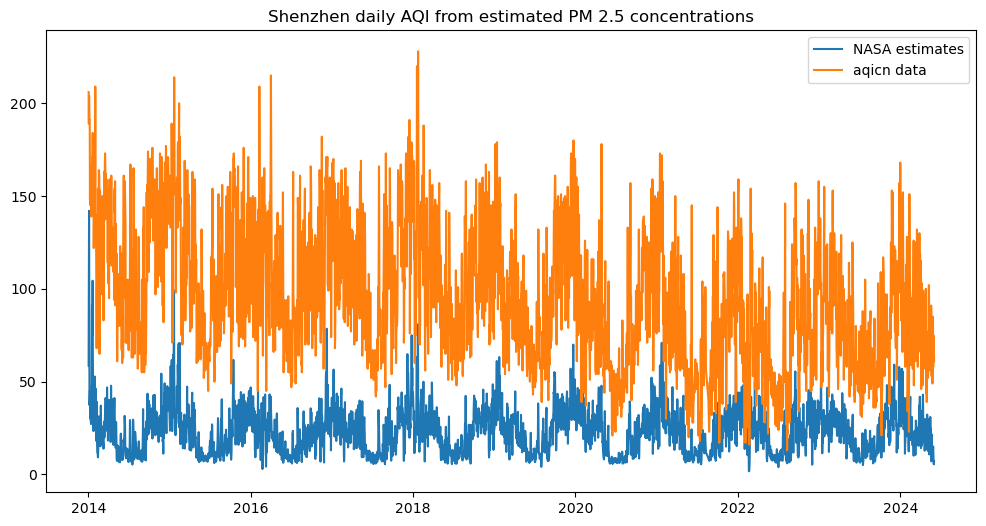

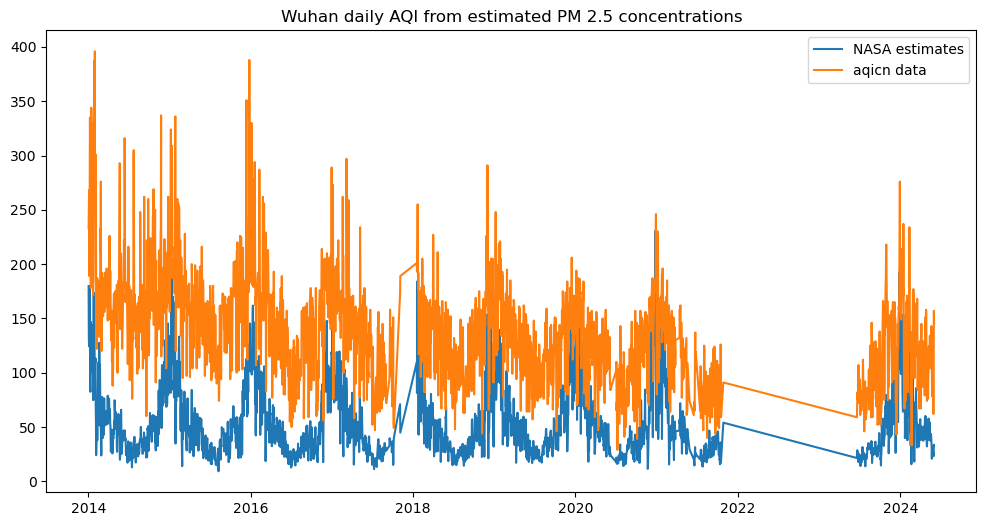

In [27]:
for i in range(0, len(merged_data)):
    pm25daily_comparison_plots(i)

Now we aggregate the data further to look at trends on a monthly timescale. 

In [50]:
monthly_NASA_data = {}
for i in list(cities_PM2point5.keys()):
    df = cities_PM2point5[i]
    df['month'] = df['day'].dt.to_period('M')
    monthly_aggregated_df = df.groupby(['month'])['pm25_µg_m3_'+i].mean().reset_index()
    monthly_aggregated_df['Converted NASA concentrations'] = monthly_aggregated_df['pm25_µg_m3_'+i].apply(lambda x: round(concentration_to_AQI(x)))
    monthly_NASA_data[i.lower()] = monthly_aggregated_df



monthly_aqicn_data = {}
for i in list(aqicn_data.keys()):
    df = aqicn_data[i]
    df = df.loc[df[' pm25'] != ' ']
    df[' pm25'] = pd.to_numeric(df[' pm25'])
    df['month'] = df['date'].dt.to_period('M')
    df = df[['month', ' pm25']]
    df.rename(columns = {'month':'month',' pm25': 'pm25_'+i.capitalize()}, inplace = True)
    monthly_aggregated_df = df.groupby(['month'])['pm25_'+i.capitalize()].mean().reset_index()
    monthly_aqicn_data[i] = monthly_aggregated_df

/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_16657/4101708662.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' pm25'] = pd.to_numeric(df[' pm25'])
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_16657/4101708662.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.to_period('M')
/var/folders/vw/gdcnwtcd5bz57ppbyy52qp8h0000gn/T/ipykernel_16657/4101708662.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [54]:
def pm25_monthly_plot(i):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(monthly_NASA_data[i]['month'].astype(str), monthly_NASA_data[i]['Converted NASA concentrations'], label = 'NASA data')
    ax.plot(monthly_aqicn_data[i]['month'].astype(str), monthly_aqicn_data[i]['pm25_'+i.capitalize()], label = 'aqicn data')
    plt.ylabel('AQI')
    plt.xticks(np.arange(0,len(monthly_aqicn_data[i]['month']),12), rotation='vertical')
    plt.title('Estimated Monthly Average PM 2.5 AQI in '+i)
    plt.legend()
    plt.show()


In [84]:
baotou_data = merged_data[0][['date',' pm25', 'converted_NASA_concentrations']]
baotou_data_weekly = baotou_data.groupby(baotou_data['date'].dt.to_period('W'))[[' pm25', 'converted_NASA_concentrations']].mean().reset_index()

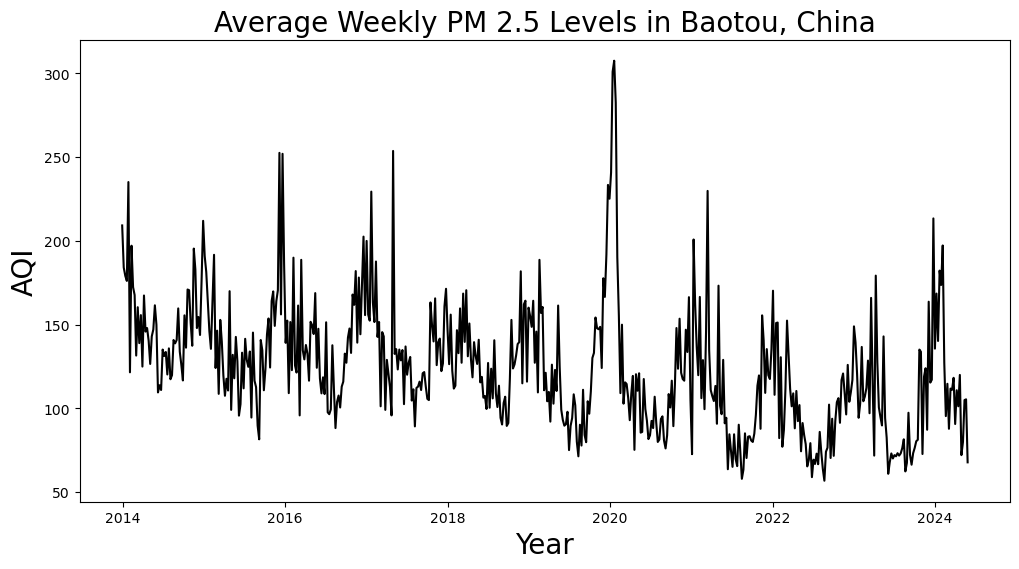

In [95]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(baotou_data_weekly['date'].dt.to_timestamp(), baotou_data_weekly[' pm25'], c = 'black')
plt.xlabel('Year', fontsize = 20)
plt.ylabel('AQI', fontsize = 20)
plt.title('Average Weekly PM 2.5 Levels in Baotou, China', fontsize = 20)
plt.show()

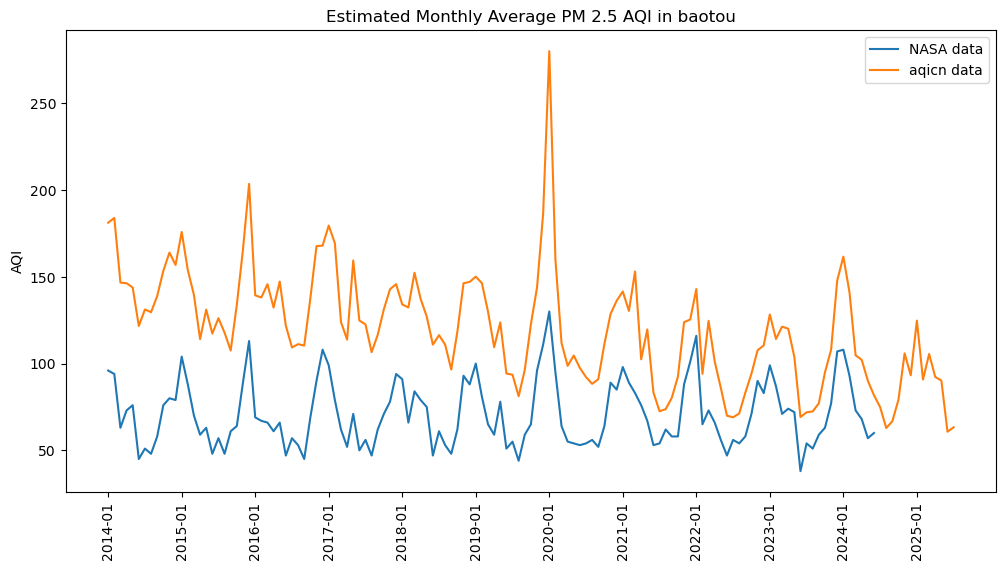

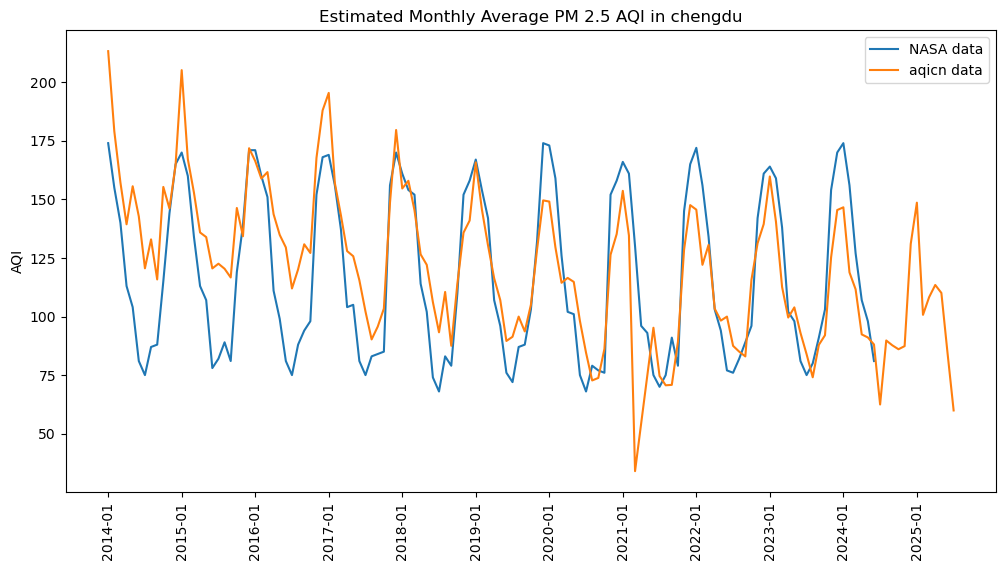

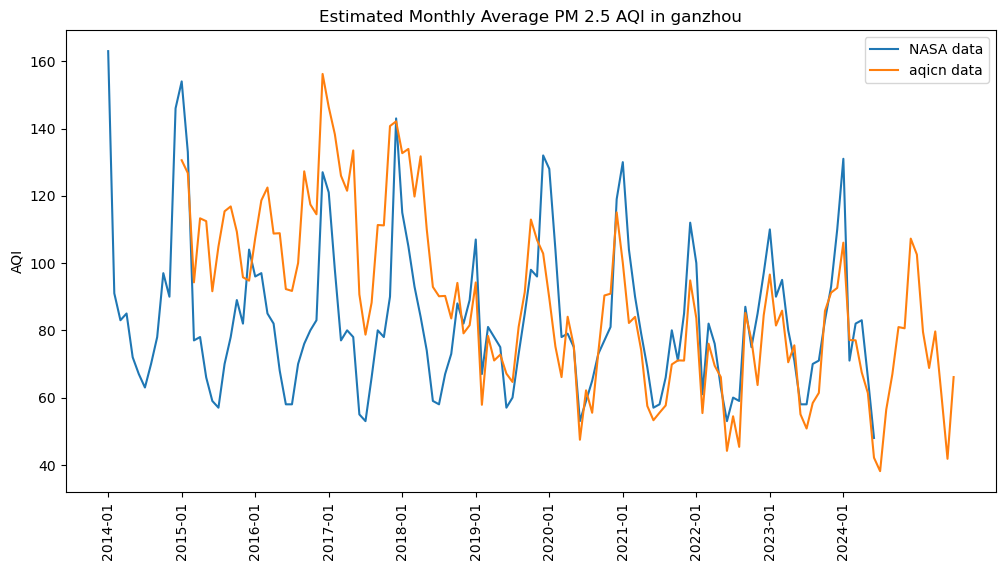

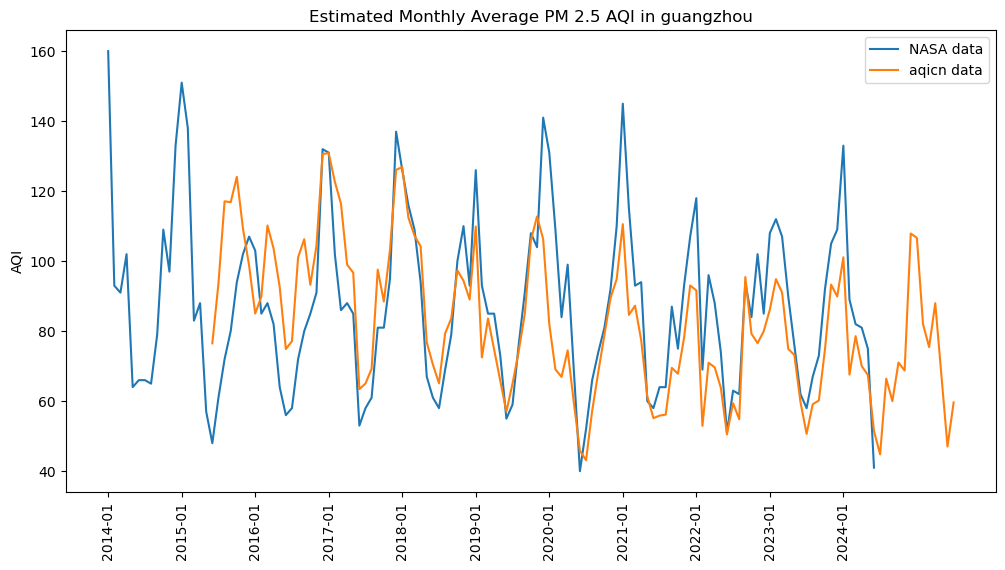

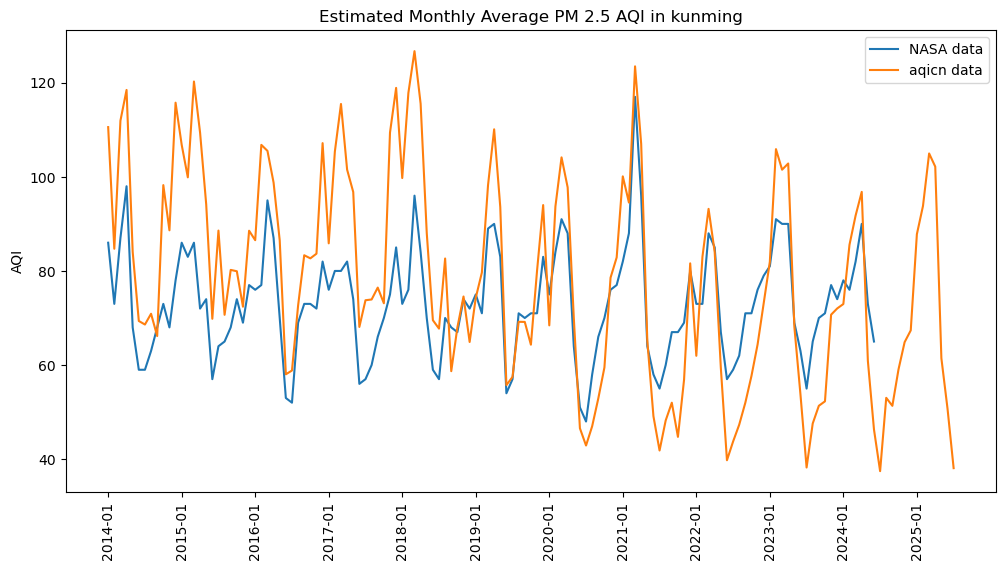

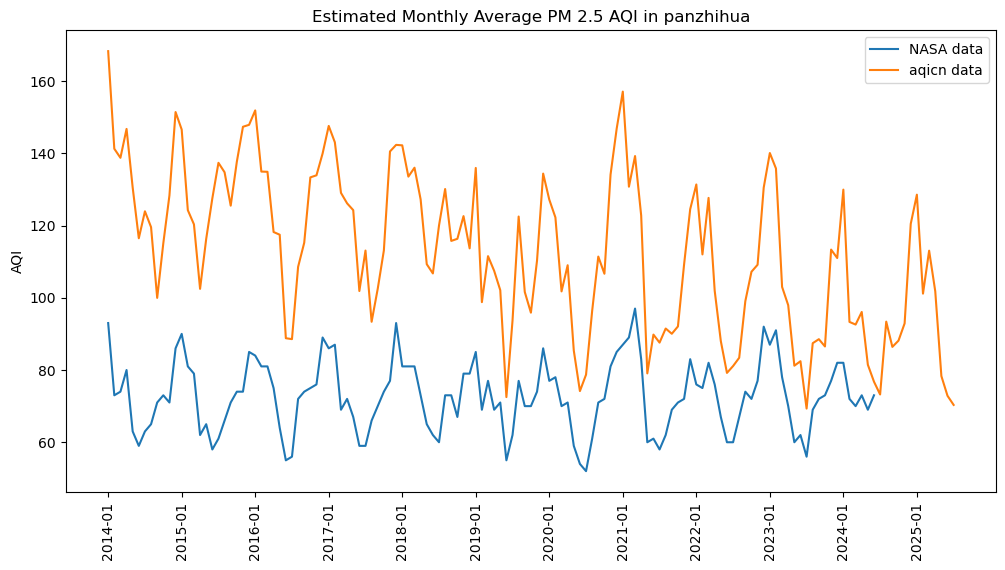

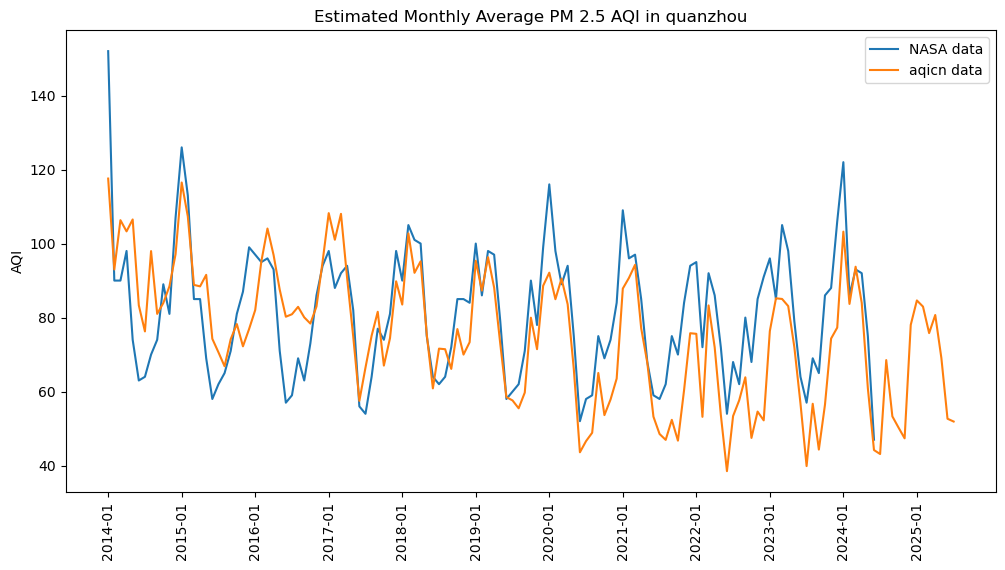

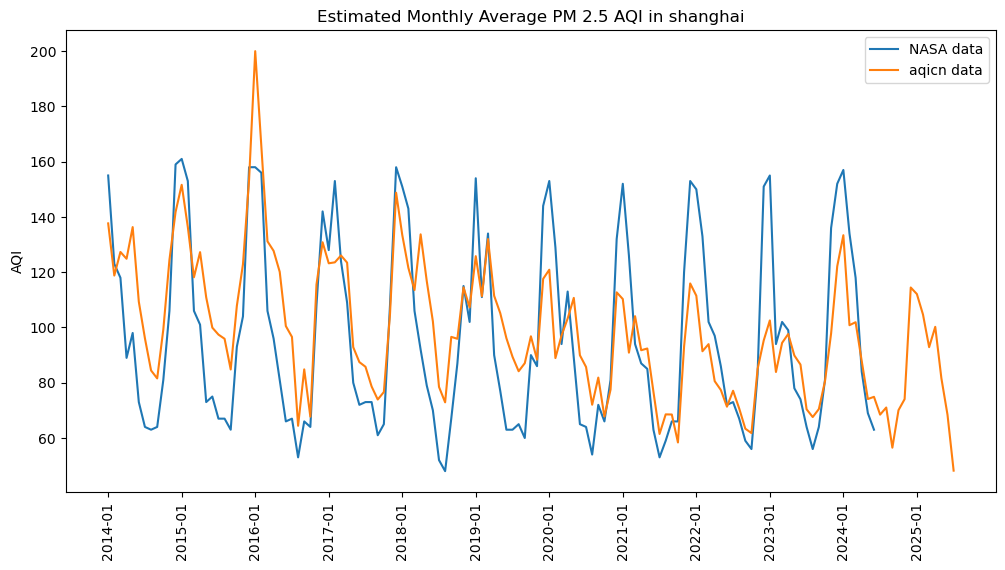

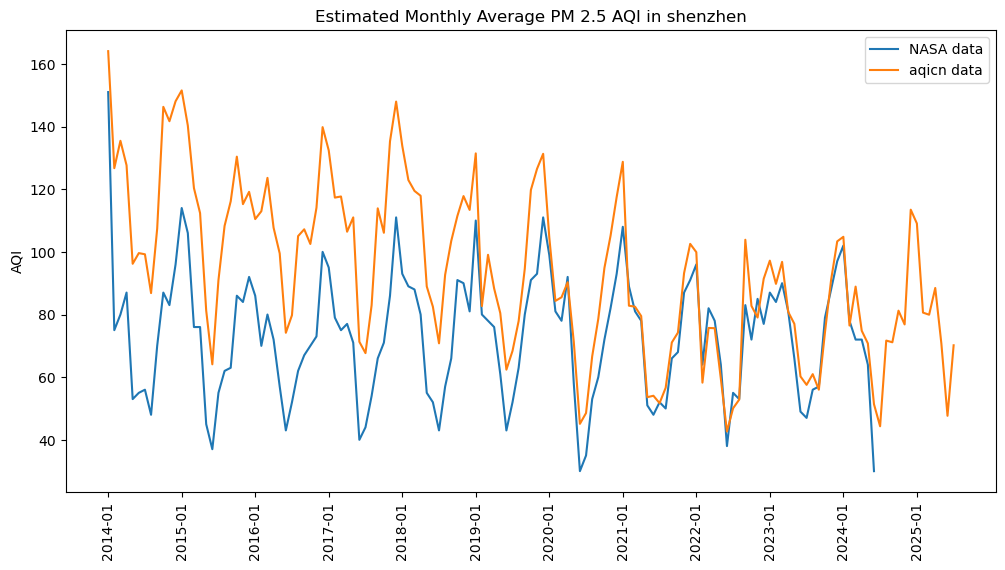

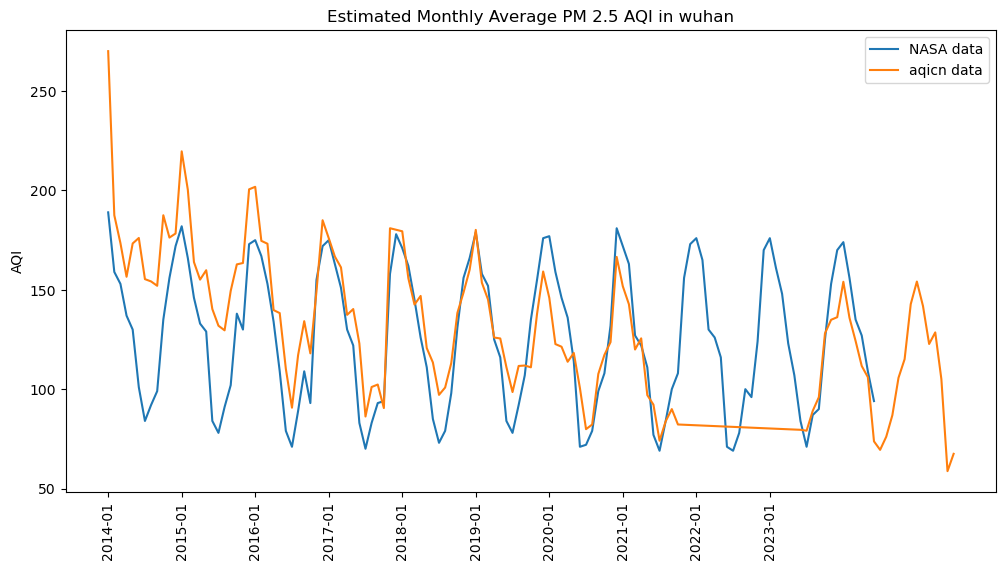

In [55]:
for i in list(aqicn_data.keys()):
    pm25_monthly_plot(i)

Finally, we do some seasonal trend decompositions to get a rough sense of the basic structural features of both the aqicn data and the NASA data. 

First, STL decomposition of the aqicn data:

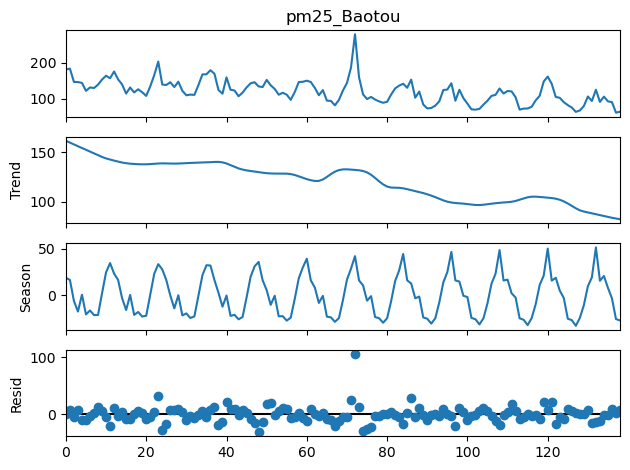

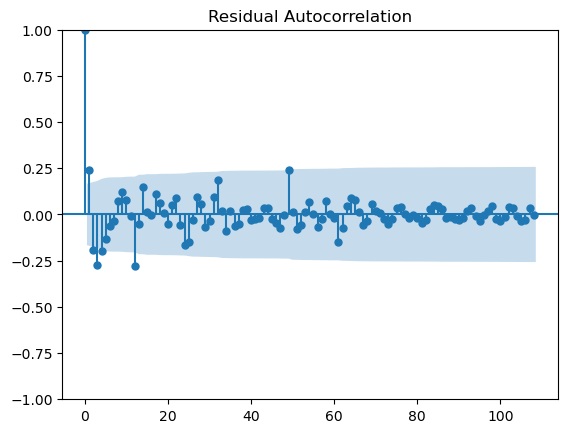

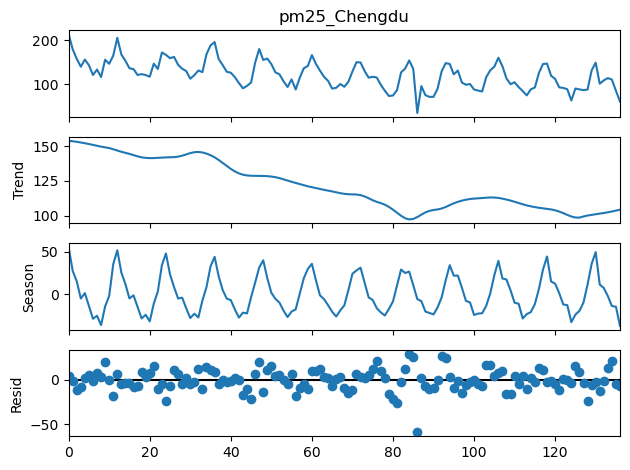

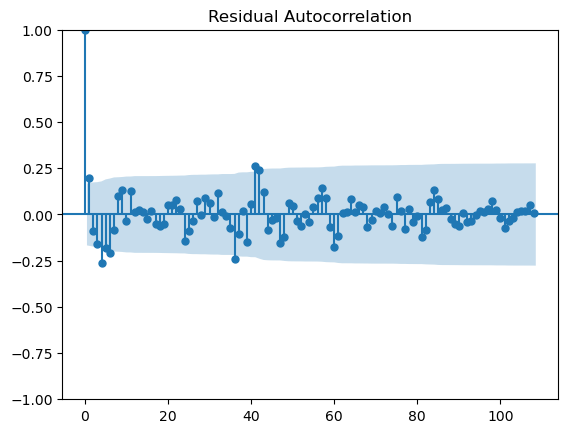

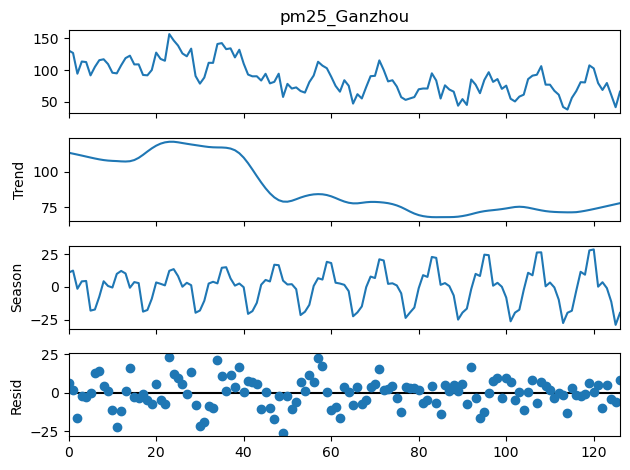

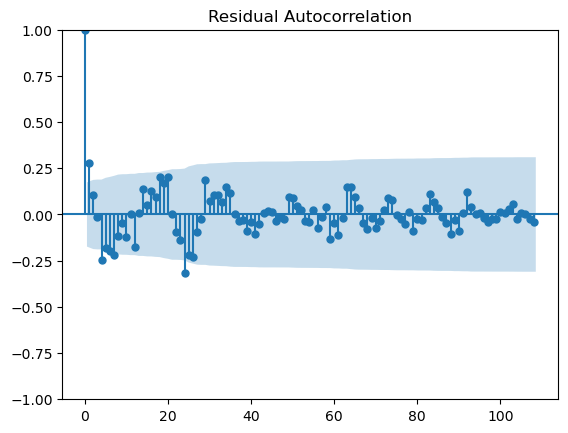

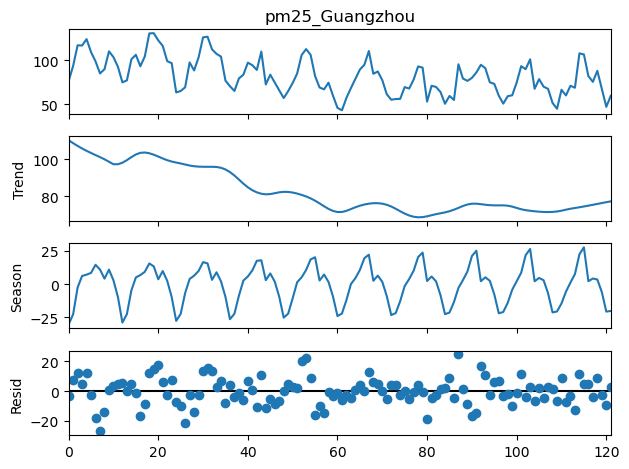

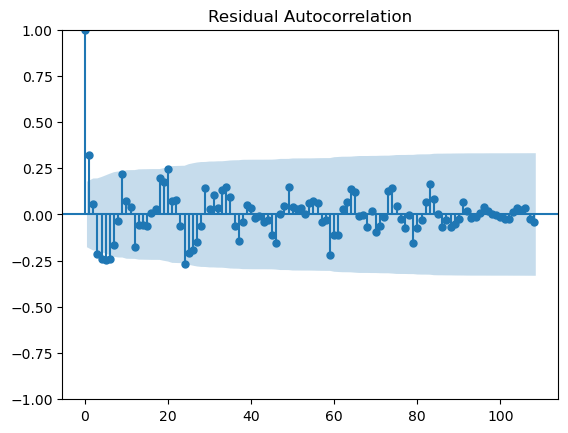

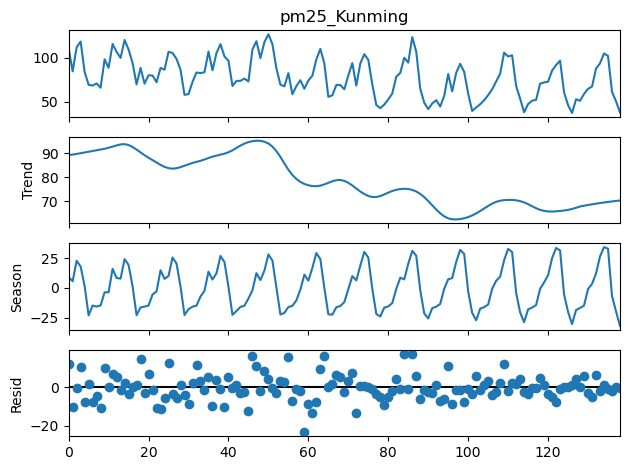

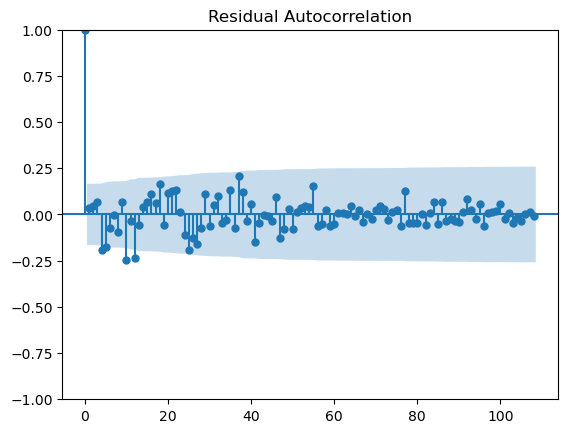

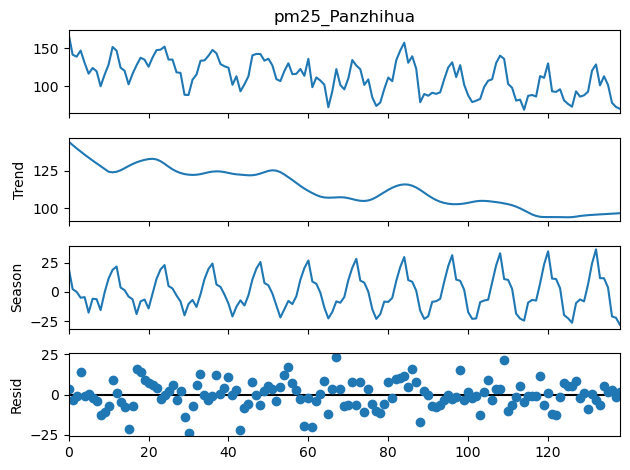

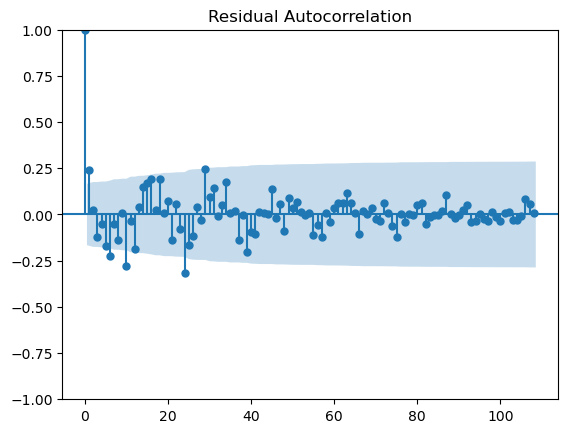

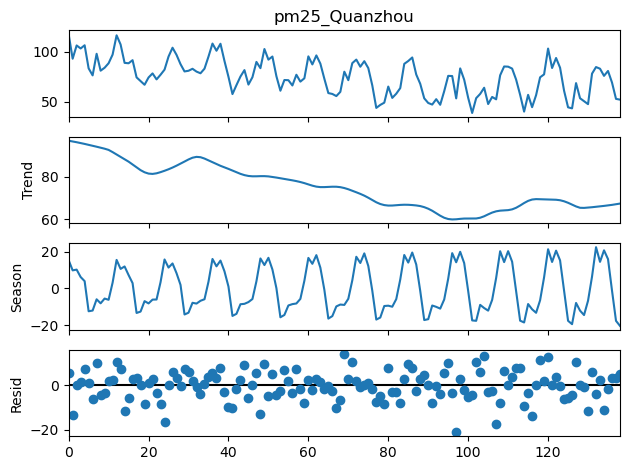

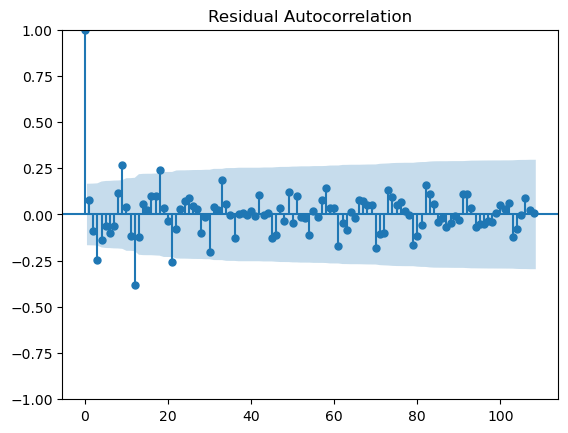

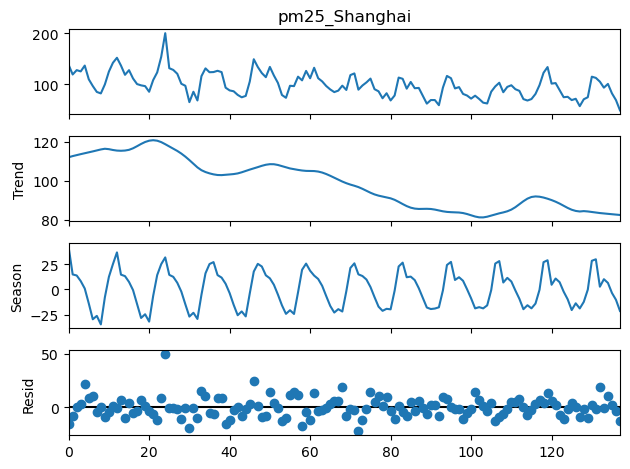

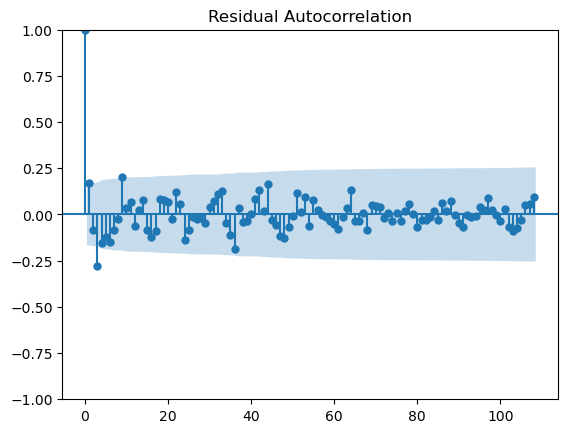

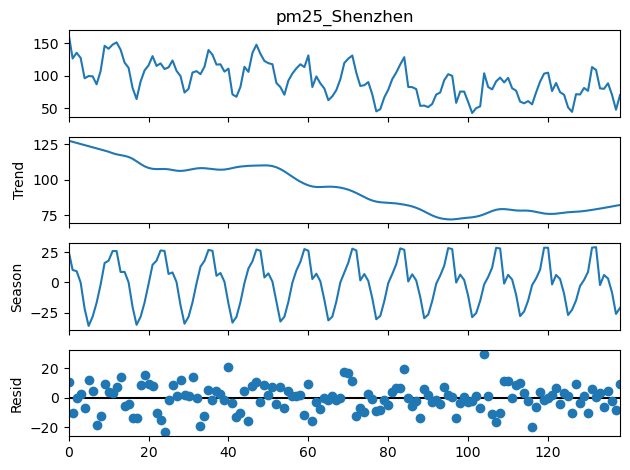

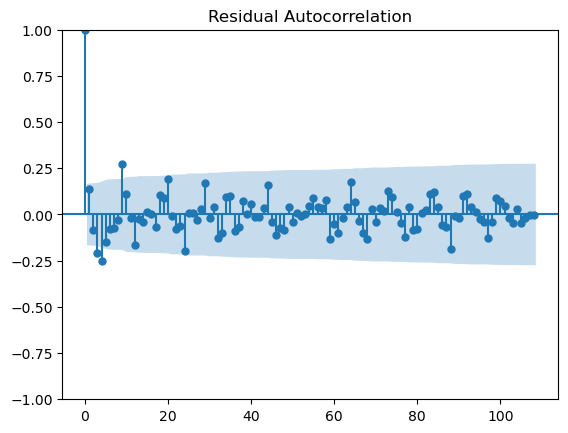

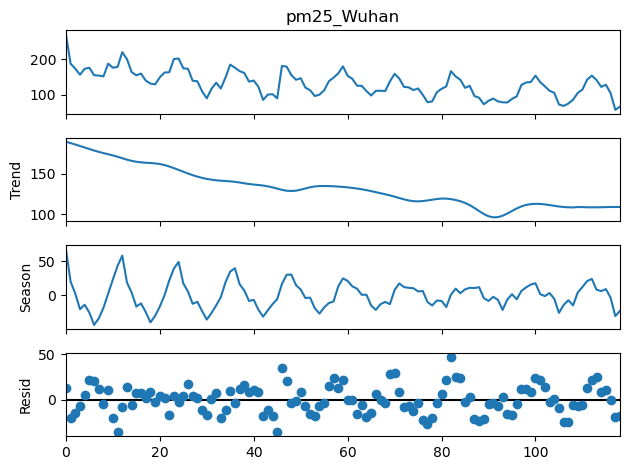

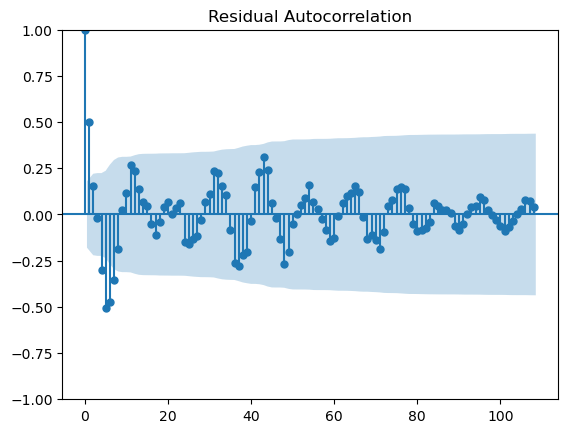

In [56]:
for i in list(monthly_aqicn_data.keys()):
    stl = tsa.seasonal.STL(monthly_aqicn_data[i].iloc[:,1], period = 12, seasonal = 19)
    fitted_model = stl.fit()
    fitted_model.plot()
    residuals = fitted_model.resid
    tsaplots.plot_acf(residuals, lags = 108, alpha = 0.05, title = 'Residual Autocorrelation')

/Users/josephmacula/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/seasonal.py:346: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(len(series), 1, sharex=True)


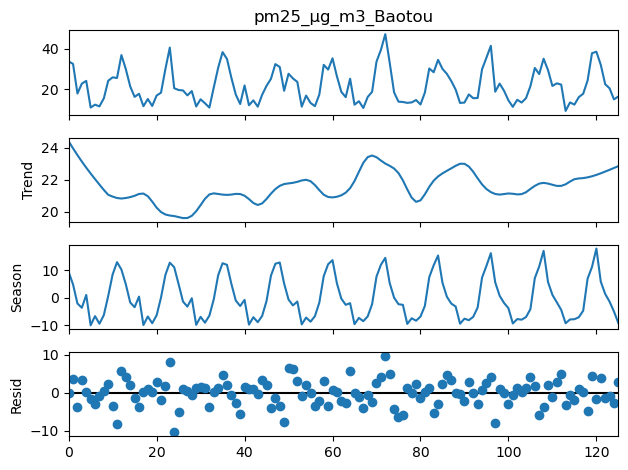

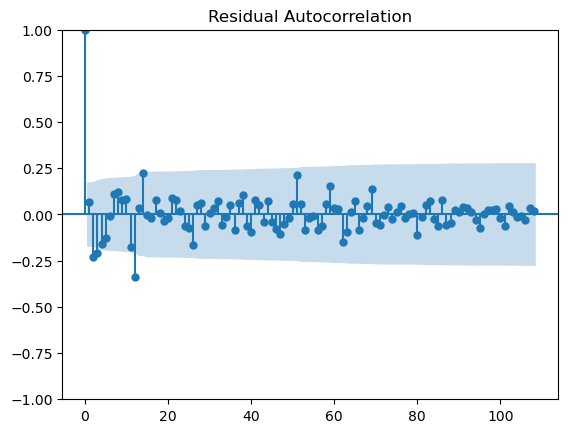

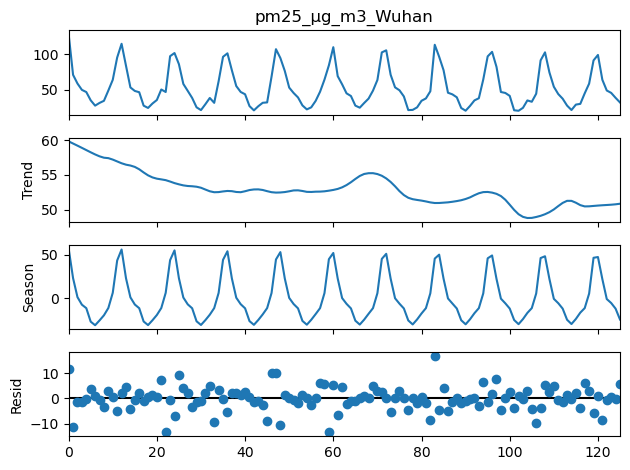

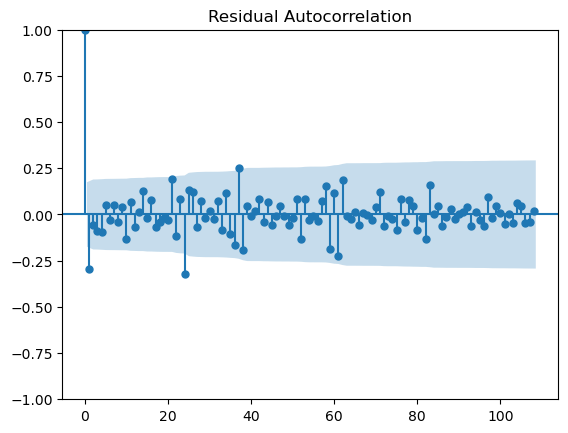

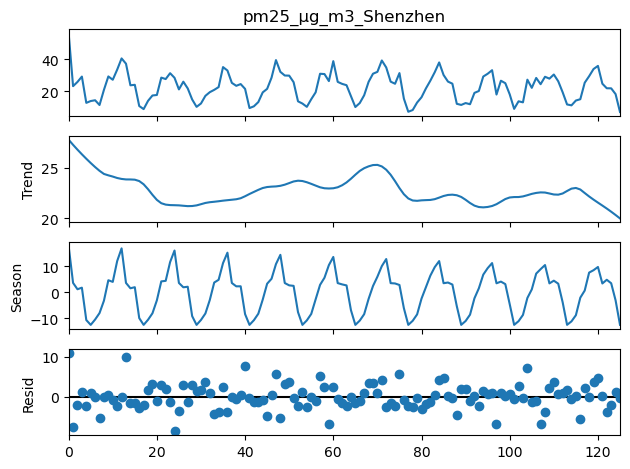

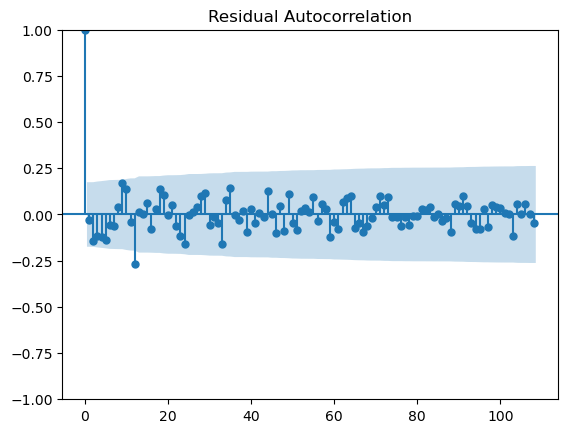

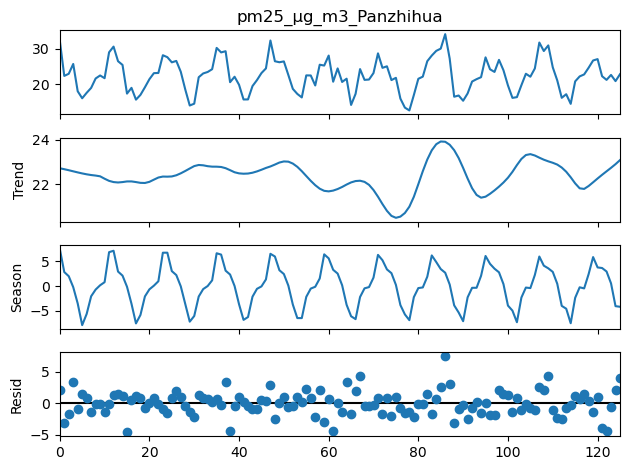

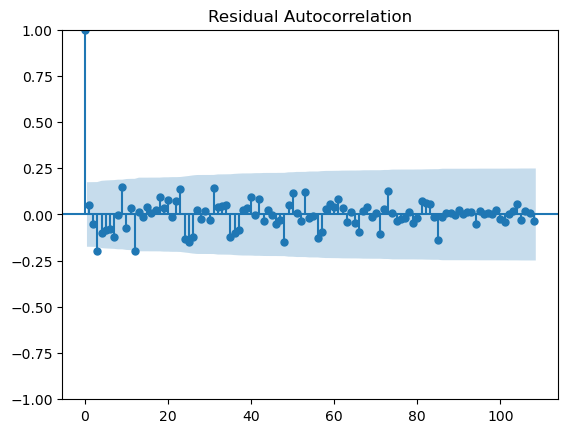

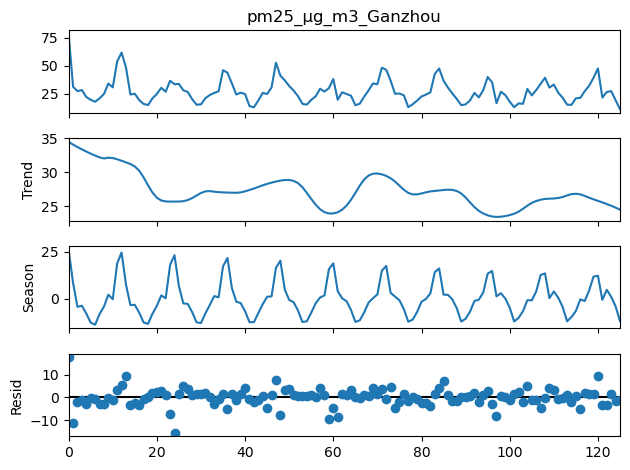

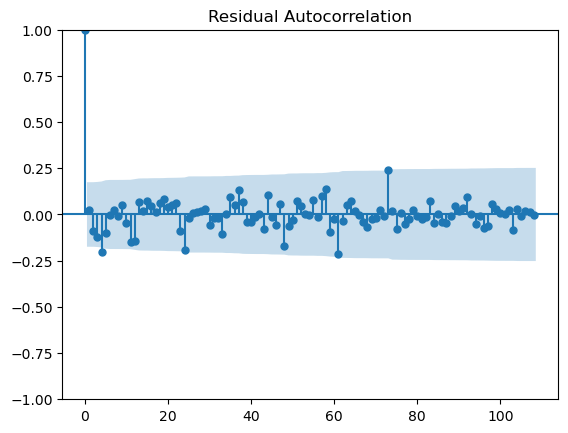

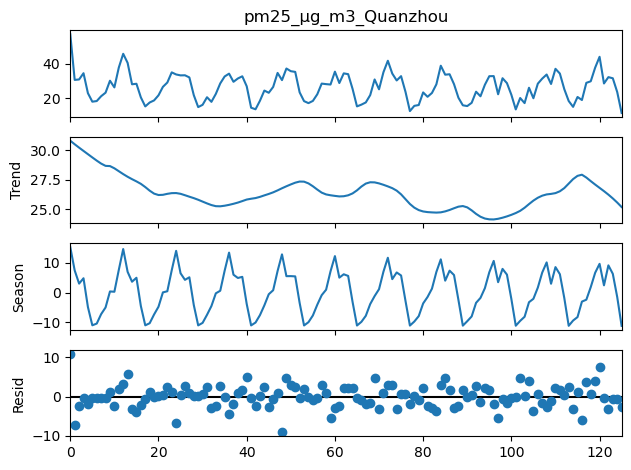

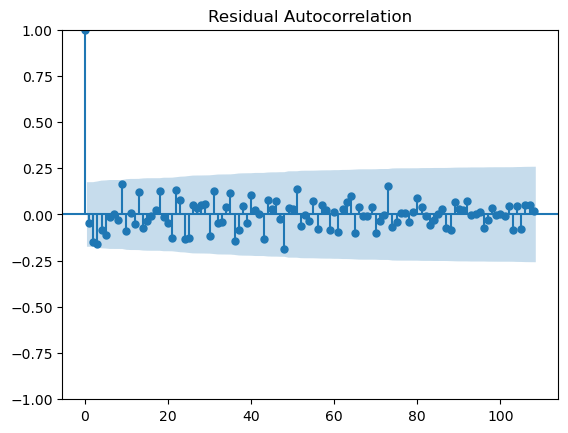

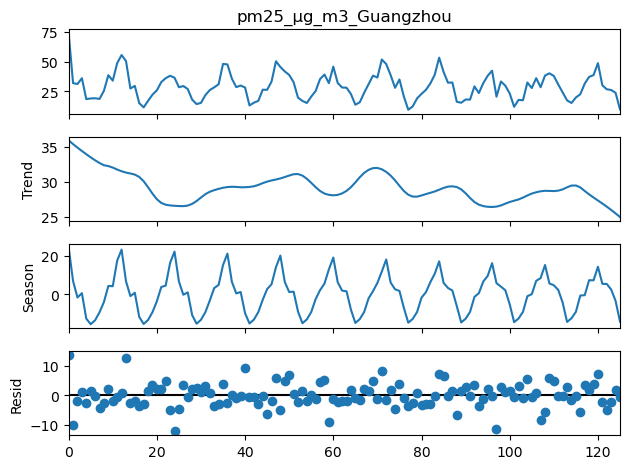

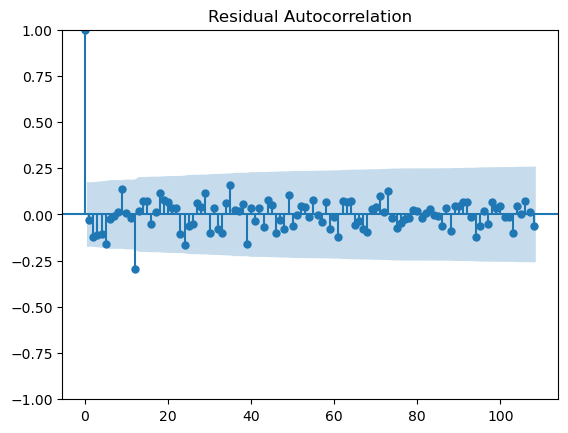

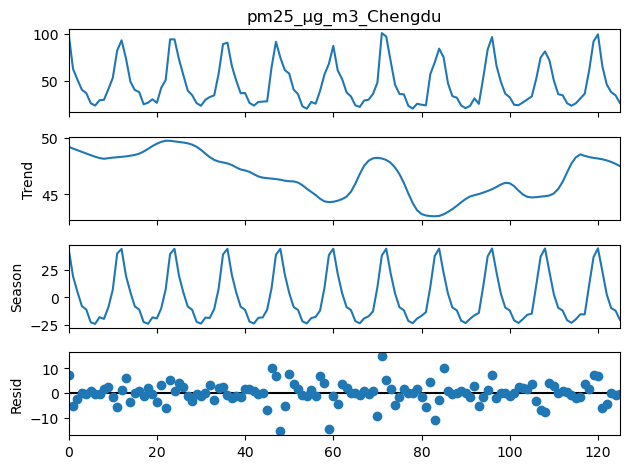

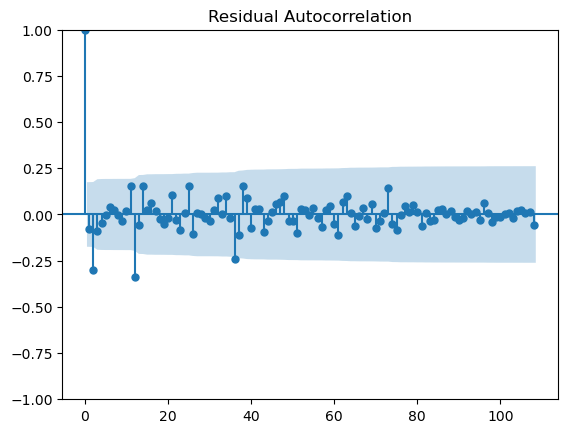

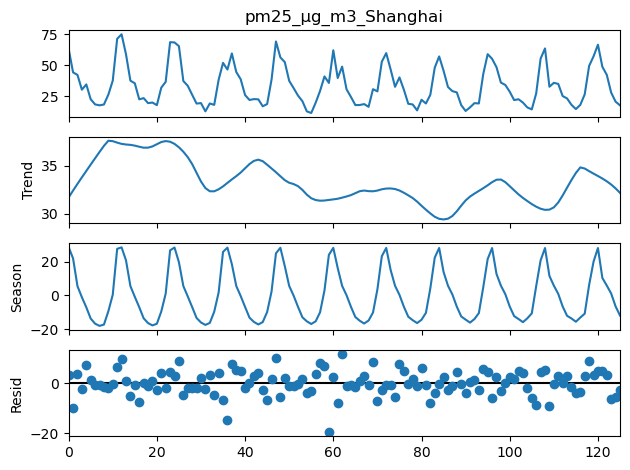

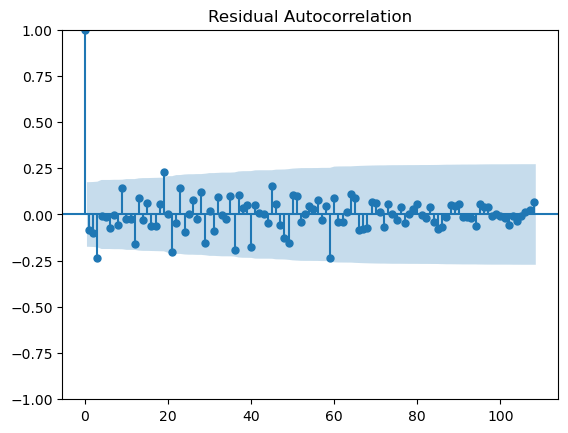

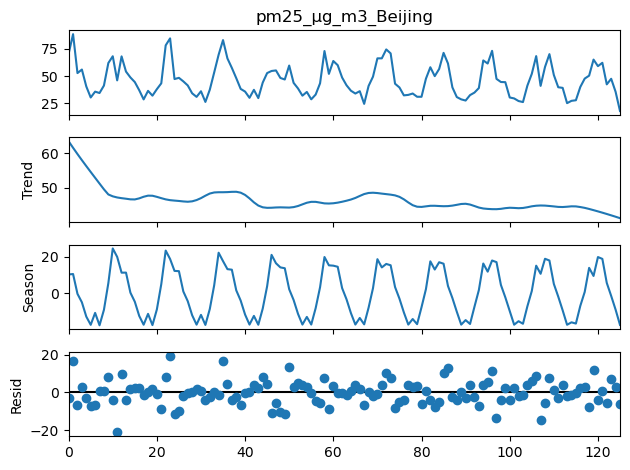

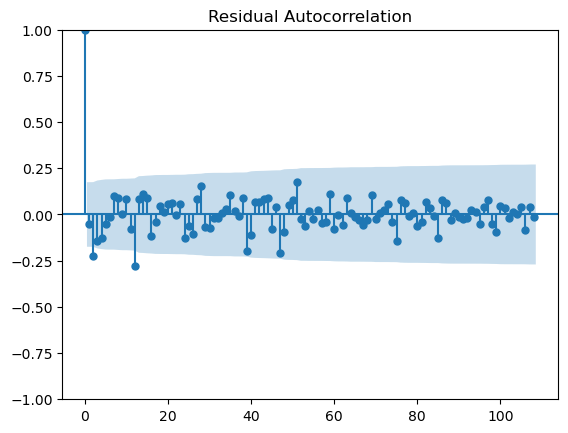

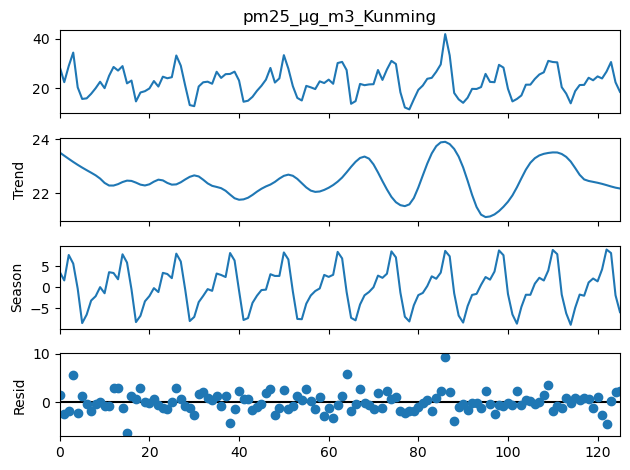

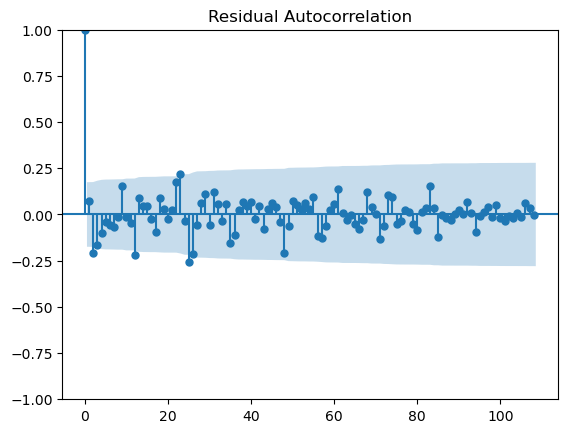

In [58]:
for i in list(monthly_NASA_data.keys()):
    stl = tsa.seasonal.STL(monthly_NASA_data[i].iloc[:,1], period = 12, seasonal = 49)
    fitted_model = stl.fit()
    fitted_model.plot()
    residuals = fitted_model.resid
    tsaplots.plot_acf(residuals, lags = 108, alpha = 0.05, title = 'Residual Autocorrelation')